# Long-term market strategy using Finviz and FinBERT

Let's try, using Finviz, to find stocks whose purchase will potentially lead to profit.

For the first strategy, we will look for stocks that have fallen more than 50% from their annual peaks, but still have good fundamentals.

In [1]:
!pip install finvizfinance -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.1 MB/s eta 0:00:00


In [2]:
!pip install goose3 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 2.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import csv
import os
import yfinance as yf
from finvizfinance.screener.overview import Overview
from finvizfinance.quote import finvizfinance
from goose3 import Goose
from requests import get
from PIL import Image
from transformers import pipeline

We will search for stocks based on the following parameters:

1. Fall of more than 50% from the annual maximum
2. Operating profit margin more than 0
3. The ratio of long-term liabilities to equity capital of the company is less than 1
4. Price-to-earnings ratio is less than 1
5. Purchases by insiders (available)

In [4]:
def get_stocks():

    foverview = Overview()
    filters = {'52-Week High/Low': '50% or more below High',
               'Debt/Equity':'Under 1',
               'PEG':'Low (<1)',
               'Operating Margin':'Positive (>0%)',
               'InsiderTransactions':'Positive (>0%)'}
    foverview.set_filter(filters_dict=filters)
    df_overview = foverview.screener_view()
    if not os.path.exists('output'):
        os.makedirs('output')
    df_overview.to_csv('output/Overview.csv', index=False)
    tickers = df_overview['Ticker'].to_list()
    return tickers

print(get_stocks())

['DCGO', 'PFIE']


/usr/local/lib/python3.10/dist-packages/finvizfinance/screener/base.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([df, pd.DataFrame(frame)], ignore_index=True)


#### Optional item: we build a chart of the stock(s) of interest, look at all the fundamental parameters, and analyze.

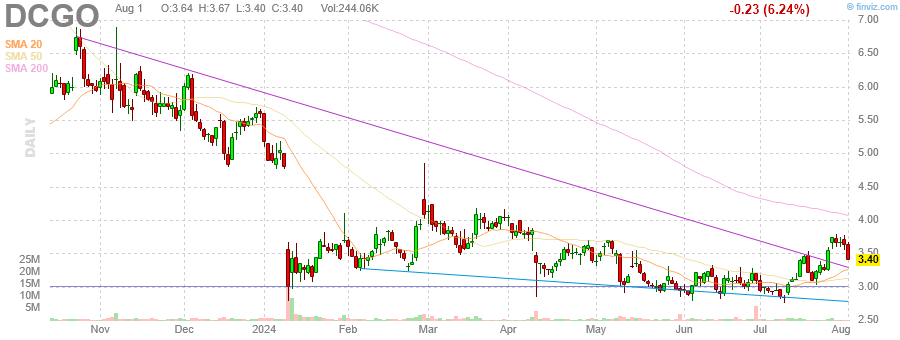

In [5]:
ticker = 'DCGO'
stock = finvizfinance(ticker)
stock.ticker_charts()
sample=Image.open(ticker+'.jpg')
sample

In [6]:
stock.ticker_fundament()

{'Company': 'DocGo Inc',
 'Sector': 'Healthcare',
 'Industry': 'Medical Care Facilities',
 'Country': 'USA',
 'Exchange': 'NASD',
 'Index': 'RUT',
 'P/E': '16.83',
 'EPS (ttm)': '0.20',
 'Insider Own': '16.75%',
 'Shs Outstand': '104.06M',
 'Perf Week': '-4.13%',
 'Market Cap': '345.69M',
 'Forward P/E': '21.46',
 'EPS next Y': '0.16',
 'Insider Trans': '0.46%',
 'Shs Float': '84.56M',
 'Perf Month': '13.83%',
 'Income': '21.55M',
 'PEG': '0.54',
 'EPS next Q': '0.06',
 'Inst Own': '46.69%',
 'Short Float': '10.13%',
 'Perf Quarter': '0.40%',
 'Sales': '703.37M',
 'P/S': '0.49',
 'EPS this Y': '316.67%',
 'Inst Trans': '20.38%',
 'Short Ratio': '8.90',
 'Perf Half Y': '-8.01%',
 'Book/sh': '3.02',
 'P/B': '1.13',
 'EPS next Y Percentage': '-36.56%',
 'ROA': '4.80%',
 'Short Interest': '8.56M',
 'Perf Year': '-59.91%',
 'Cash/sh': '0.41',
 'P/C': '8.38',
 'EPS next 5Y': '31.07%',
 'ROE': '7.31%',
 '52W Range From': '2.75',
 '52W Range To': '10.82',
 'Perf YTD': '-39.11%',
 'Dividend Est

#### Let's analyze the mood in the news about the selected stocks

To do this, we use a function that gets a list of the latest news for a certain ticker, then determines the mood of the entire news using FinBERT (if it is short - less than 512 characters), and if the news is long, then the mood of the headline.

We format the results into a dataset. Then we run the function for each ticker found earlier. And then we open the received datasets, study them. If positive news prevails, then we can take the stock for the long term.

In [7]:
def get_ticker_news_sentiment(ticker):
    ticker_news = yf.Ticker(ticker)
    news_list = ticker_news.get_news()
    extractor = Goose()
    pipe = pipeline("text-classification", model="ProsusAI/finbert")
    data = []
    for dic in news_list:
        title = dic['title']
        response = get(dic['link'])
        article = extractor.extract(raw_html=response.content)
        text = article.cleaned_text
        date = dic['providerPublishTime']
        if len(text) > 512:
            results1 = pipe(title)
            data.append({'date':f'{date}',
                         'title':f'{title}',
                         'sentiment':results1[0]['label']})
        else:
            results = pipe(text)
            #print(results)
            data.append({'date':f'{date}',
                         'title':f'{title}',
                         'sentiment':results[0]['label']})
    df = pd.DataFrame(data)
    return df

def generate_csv(ticker):
    get_ticker_news_sentiment(ticker).to_csv(f'{ticker}.csv', index=False)

In [8]:
undervalued = get_stocks()
for ticker in undervalued:
    generate_csv(ticker)
    data = pd.read_csv(ticker+'.csv')
    data['date']=pd.to_datetime(data['date'], unit='s')
    data['date'] = data['date'].dt.strftime('%Y-%m-%d')
    print(ticker)
    print(data)

/usr/local/lib/python3.10/dist-packages/finvizfinance/screener/base.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([df, pd.DataFrame(frame)], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

DCGO
         date                                              title sentiment
0  2024-07-31  DocGo Launches Well Child Visits Program to He...  positive
1  2024-07-29  DocGo Announces Upcoming Participation at Cana...   neutral
2  2024-07-22  DocGo to Announce Second Quarter 2024 Results ...   neutral
3  2024-07-15  Ambulnz by DocGo Launches Emergency Medical Se...   neutral
4  2024-07-09  DocGo and Spect Partner to Reduce Care Gaps an...  positive
5  2024-06-24  DocGo Secures Five New Contracts to Provide He...  positive
6  2024-06-20  DocGo to Participate in the iAccess Alpha Buys...  positive
7  2024-06-17           DocGo Establishes Medical Advisory Board  positive
PFIE
         date                                              title sentiment
0  2024-07-24  Profire Energy Sets Second Quarter 2024 Earnin...   neutral
1  2024-06-28  Is Profire Energy, Inc. (NASDAQ:PFIE) Trading ...  positive
2  2024-06-24  Zacks Industry Outlook Highlights Kodiak Gas S...  positive
3  2024-06-21  

So we found two tickers with the parameters we are interested in and having positive news, suitable for long-term purchase.